In [150]:
import os
import pandas as pd
import plotting
import importlib
importlib.reload(plotting)
import math
import numpy as np

# Load in all depth vs resistance curves into a dataframe list

In [151]:
def load_data(data_src):
    depth_resist_curve_df_list = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        depth_resist_curve_df_list.append(df)
        filename_list.append(filename)
    return depth_resist_curve_df_list, filename_list

data_src = "data/cleaned_data"
depth_resist_curve_df_list, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, depth_resist_curve_df_list))

# Seperate clustering data from meta-data

In [152]:
data_features_df = pd.read_csv("data/features.csv")
metadata_list = ['filenames', 'feifeis_ylabels', 'liams_ylabels', 'marions_ylabels', 'distances']
clustering_features_df = data_features_df.drop(metadata_list, axis=1)

# Clustering Marion's Labels

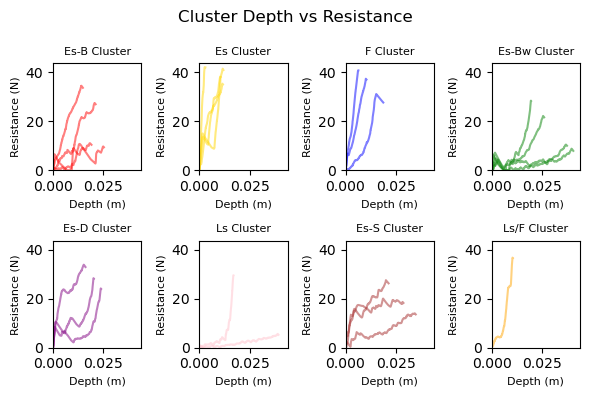

Index([0, 26, 39, 49], dtype='int64')
Index([8, 25, 48, 71], dtype='int64')


In [153]:
marions_labeled_data = data_features_df[data_features_df['marions_ylabels'].notna()].copy() # removes NaN's which correspond to non-labled data
# encodes object into categorical variables
marions_labeled_data['encoded'], uniques = pd.factorize(marions_labeled_data['marions_ylabels'])

plotting.plot_clusters_seperately(marions_labeled_data['encoded'].tolist(), marions_labeled_data.index.tolist(), depth_resist_curve_df_list, data_features_df, 
                         cluster_category_names=uniques.tolist())
plotting.plot_pca(marions_labeled_data, marions_labeled_data['encoded'], 3, graph_title='marions_ylabels')

print(marions_labeled_data[marions_labeled_data['encoded'] == 0].index)
print(marions_labeled_data[marions_labeled_data['encoded'] == 1].index)


# Marion's Centroid Clustering

In [154]:
def find_marions_labels_means(marions_labeled_data: pd.DataFrame) -> pd.DataFrame:
    # remove non-important cols
    marions_labeled_data = marions_labeled_data.copy()
    numerical_data = plotting.extract_numerical_features(marions_labeled_data)
    marions_labeled_data['encoded'], uniques = pd.factorize(marions_labeled_data['marions_ylabels'])
    label_centroids = []
    for label_num, label_name in enumerate(uniques):
        label_features = numerical_data[marions_labeled_data['encoded'] == label_num]
        label_centroid = label_features.mean(axis=0).tolist() # drop cols for mean calculation
        label_centroid.extend([label_name, label_num])

        label_centroids.append(label_centroid)
    return_cols = numerical_data.columns.tolist()
    return_cols.extend(['marions_ylabels', 'encoded'])
    return pd.DataFrame(data=label_centroids, columns=return_cols)

def euclidean_distance(x: pd.DataFrame, y: pd.DataFrame) -> float:
    inner_sum = 0
    for idx in range(len(x)):
        inner_sum += (y.iloc[idx] - x.iloc[idx])**2
    return math.sqrt(inner_sum)

def find_closest_centroid(unlabeled_data_df:pd.DataFrame, marions_centroids:pd.DataFrame) -> pd.DataFrame:
    unlabeled_data_df = unlabeled_data_df.copy()
    unlabeled_data_df = plotting.extract_numerical_features(unlabeled_data_df)
    
    psuedo_label_list = []
    unlabeled_data_df = unlabeled_data_df.copy()
    for i, depth_res_curve in unlabeled_data_df.iterrows():
        min_distance = float('inf')
        min_distance_label = ''
        for j, marions_label_mean in marions_centroids.iterrows():
            curve_to_label_mean_distance = euclidean_distance(depth_res_curve, marions_label_mean)
            if curve_to_label_mean_distance < min_distance:
                min_distance = curve_to_label_mean_distance
                min_distance_label = marions_label_mean['marions_ylabels']
        psuedo_label_list.append(min_distance_label)
    unlabeled_data_df['marions_pseudo_labels'] = psuedo_label_list
    return unlabeled_data_df

marions_label_centroids = find_marions_labels_means(marions_labeled_data)
psuedo_labeled_data = find_closest_centroid(data_features_df, marions_label_centroids)

psuedo_labeled_data['encoded'], uniques = pd.factorize(psuedo_labeled_data['marions_pseudo_labels'])
plotting.plot_pca(psuedo_labeled_data, psuedo_labeled_data['encoded'], 3, 
    graph_title='marions_psuedo_labels', kmeans_centroids=marions_label_centroids)

# Clustering FeiFei's Labels

In [155]:
# feifeis_features_df = data_features_df[data_features_df['feifeis_ylabels'].notna()].copy() # removes NaN's which correspond to non-labled data
# feifeis_features_df['encoded'], uniques = pd.factorize(feifeis_features_df['feifeis_ylabels'])
# y_labels = feifeis_features_df['encoded'].to_list()
# plotting.plot_clusters_seperately(y_labels, feifeis_features_df.index, depth_resist_curve_df_list, data_features_df, cluster_category_names=uniques.to_list(), filenames=False)
# data_features_df[['filenames', 'feifeis_ylabels']][data_features_df['feifeis_ylabels'] == 'crusty ripple'].to_csv('filename_feiei_label.csv')

# Clustering Liam's Labels

In [156]:
# plot_clusters_together(y_labels=data_features_df['liams_ylabels'])
# plotting.plot_clusters_seperately(data_features_df['liams_ylabels'], data_features_df.index.tolist(), depth_resist_curve_df_list, data_features_df)